In [1]:
%matplotlib inline
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.stats import stats
import itertools

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.dummy import DummyClassifier

In [2]:
#labels
dfAll = pd.read_csv('./../out/Allevent.txt',encoding='utf-16',index_col=0)
eventLabel=pd.DataFrame()
eventLabel['eventidx']=dfAll.index
eventLabel['valence']=dfAll['valence'].map(lambda x: 1 if x >0 else 0)
eventLabel['arousal']=dfAll['arousal'].map(lambda x: 1 if x >1 else 0)
eventLabel.set_index('eventidx',inplace=True)


eventdf=pd.get_dummies(dfAll.event)
emodf=pd.get_dummies(dfAll.emotions)

eventLabel=pd.concat([eventLabel,emodf],axis=1)
eventLabel.head()

,valence,arousal,colere,ennui,fierte,frustration,joie,neutre,peur
eventidx,,,,,,,,,
0,0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [3]:
phyEventdf10=pd.read_csv('./../out/feature/phyEvent10s.csv',encoding='utf-16',index_col='eventidx')
phyEventdf14=pd.read_csv('./../out/feature/phyEvent14s.csv',encoding='utf-16',index_col='eventidx')
phyEventdf20=pd.read_csv('./../out/feature/phyEvent20s.csv',encoding='utf-16',index_col='eventidx')
phyEventdf30=pd.read_csv('./../out/feature/phyEvent30s.csv',encoding='utf-16',index_col='eventidx')

dfLens=[phyEventdf10,phyEventdf14,phyEventdf20,phyEventdf30]
(featureTrans10,featureTrans14,featureTrans20,featureTrans30)=[df.groupby('sujet').transform(lambda x: (x - x.mean()) / x.std()) for df in dfLens]

phyEventNormdf10=pd.concat([phyEventdf10['sujet'], featureTrans10], axis=1)
phyEventNormdf14=pd.concat([phyEventdf14['sujet'], featureTrans14], axis=1)
phyEventNormdf20=pd.concat([phyEventdf20['sujet'], featureTrans20], axis=1)
phyEventNormdf30=pd.concat([phyEventdf30['sujet'], featureTrans30], axis=1)

phyEventNormdf10n=phyEventNormdf10.dropna(axis=1,how='any')
phyEventNormdf14n=phyEventNormdf14.dropna(axis=1,how='any')
phyEventNormdf20n=phyEventNormdf20.dropna(axis=1,how='any')
phyEventNormdf30n=phyEventNormdf30.dropna(axis=1,how='any')

DF={'10s':phyEventNormdf10n,
     '14s':phyEventNormdf14n,
     '20s':phyEventNormdf20n,
     '30s':phyEventNormdf30n}

In [8]:
#apprentissage
def meanstd(scores):
    return "{0:.3f} ({1:.3f})".format(scores.mean(),np.std(scores))

scoresls=["accuracy","f1"]
names=['RF','dummy']
classifiers=[RandomForestClassifier(max_depth=5, n_estimators=50),DummyClassifier(strategy='stratified',random_state=0)]

cmpclassifierdf=pd.DataFrame()
for DFname, X in DF.iteritems():
    print("=============")
    print(DFname)
    Xn=X.dropna(axis=1,how='any')
    y_all=eventLabel.ix[18:,:]
    X_y=pd.concat([Xn,y_all],axis=1,join='inner')
    for label in list((eventLabel.columns.values).astype(str)):
        print('  '+label)
        y=X_y.loc[:,label]
        Xn=X_y.iloc[:,:-9]
        for name, clf in zip(names, classifiers):
            print('     '+name)
            scores_a = cross_val_score(clf, Xn, y, scoring="accuracy",cv=10)
            scores_f = cross_val_score(clf, Xn, y, scoring="f1",cv=10)
            ncmp=pd.DataFrame({'DFname':DFname,'label':label,'clf':name,'accuracy':meanstd(scores_a),'F1':meanstd(scores_f) }, index=[0])
            cmpclassifierdf=cmpclassifierdf.append(ncmp)


    #print("{0:.3f} (std: {1:.3f})".format(scores.mean(),np.std(scores)))

10
  valence
     RF
     dummy
  arousal
     RF
     dummy
  colere
     RF
     dummy
  ennui
     RF
     dummy
  fierte
     RF
     dummy
  frustration
     RF
     dummy
  joie
     RF
     dummy
  neutre
     RF
     dummy
  peur
     RF
     dummy
30
  valence
     RF
     dummy
  arousal
     RF
     dummy
  colere
     RF
     dummy
  ennui
     RF
     dummy
  fierte
     RF
     dummy
  frustration
     RF
     dummy
  joie
     RF
     dummy
  neutre
     RF
     dummy
  peur
     RF
     dummy
20
  valence
     RF
     dummy
  arousal
     RF
     dummy
  colere
     RF
     dummy
  ennui
     RF
     dummy
  fierte
     RF
     dummy
  frustration
     RF
     dummy
  joie
     RF
     dummy
  neutre
     RF
     dummy
  peur
     RF
     dummy
14
  valence
     RF
     dummy
  arousal
     RF
     dummy
  colere
     RF
     dummy
  ennui
     RF
     dummy
  fierte
     RF
     dummy
  frustration
     RF
     dummy
  joie
     RF
     dummy
  neutre
     RF
     dumm

In [24]:
cmpclassifierdf[cmpclassifierdf['DFname']=='30']

,DFname,F1,accuracy,clf,label
0,30,0.000 (0.000),0.695 (0.002),RF,valence
0,30,0.270 (0.065),0.566 (0.038),dummy,valence
0,30,0.394 (0.130),0.475 (0.067),RF,arousal
0,30,0.476 (0.029),0.463 (0.029),dummy,arousal
0,30,0.012 (0.035),0.826 (0.003),RF,colere
0,30,0.213 (0.059),0.731 (0.020),dummy,colere
0,30,0.000 (0.000),0.979 (0.003),RF,ennui
0,30,0.000 (0.000),0.965 (0.000),dummy,ennui
0,30,0.000 (0.000),0.922 (0.002),RF,fierte
0,30,0.058 (0.071),0.850 (0.011),dummy,fierte


In [21]:
tmp=pd.melt(cmpclassifierdf, id_vars=['DFname','clf','label'], value_vars=['F1', 'accuracy'])
tmp.head()

,DFname,clf,label,variable,value
0,10,RF,valence,F1,0.000 (0.000)
1,10,dummy,valence,F1,0.275 (0.052)
2,10,RF,arousal,F1,0.370 (0.098)
3,10,dummy,arousal,F1,0.479 (0.033)
4,10,RF,colere,F1,0.000 (0.000)


In [22]:
pd.pivot_table(tmp, values='value', index=['DFname','clf'], columns=['label','variable'])

DataError: No numeric types to aggregate

In [26]:
feapattern=["ECG.*","fEMG.*","EDA.*","Resp.*"]

names = ["DummyClassifier",
         "Random Forest"]
classifiers = [
    DummyClassifier(strategy='stratified',random_state=0),
    RandomForestClassifier(max_depth=5, n_estimators=50)
    ]

feanames=X.columns.values

cmpclassifierdf=pd.DataFrame()
for DFname, X in DF.iteritems():
    print("=============")
    print(DFname)
    Xn=X.dropna(axis=1,how='any')
    y_all=eventLabel.ix[18:,:]
    X_y=pd.concat([Xn,y_all],axis=1,join='inner')
    for pattern in feapattern:
        print(" "+pattern)
        regexb=re.compile(pattern)
        selectf=[m.group(0) for l in feanames for m in [regexb.search(l)] if m]
        Xn_s=X_y[list(set(selectf) & set(X_y.columns.values))]
        for label in list((eventLabel.columns.values).astype(str)):
            print('  '+label)
            y=X_y.loc[:,label]
            for name, clf in zip(names, classifiers):
                print('    '+name)
                scores_a = cross_val_score(clf, Xn, y, scoring="accuracy",cv=10)
                scores_f = cross_val_score(clf, Xn, y, scoring="f1",cv=10)
                ncmp=pd.DataFrame({'DFname':DFname,'signal':pattern,'label':label,'clf':name,'accuracy':meanstd(scores_a),'F1':meanstd(scores_f) }, index=[0])
                cmpclassifierdf=cmpclassifierdf.append(ncmp)

10
 ECG.*
  valence
    DummyClassifier
    Random Forest
  arousal
    DummyClassifier
    Random Forest
  colere
    DummyClassifier
    Random Forest
  ennui
    DummyClassifier
    Random Forest
  fierte
    DummyClassifier
    Random Forest
  frustration
    DummyClassifier
    Random Forest
  joie
    DummyClassifier
    Random Forest
  neutre
    DummyClassifier
    Random Forest
  peur
    DummyClassifier
    Random Forest
 fEMG.*
  valence
    DummyClassifier
    Random Forest
  arousal
    DummyClassifier
    Random Forest
  colere
    DummyClassifier
    Random Forest
  ennui
    DummyClassifier
    Random Forest
  fierte
    DummyClassifier
    Random Forest
  frustration
    DummyClassifier
    Random Forest
  joie
    DummyClassifier
    Random Forest
  neutre
    DummyClassifier
    Random Forest
  peur
    DummyClassifier
    Random Forest
 EDA.*
  valence
    DummyClassifier
    Random Forest
  arousal
    DummyClassifier
    Random Forest
  colere
    DummyClassifier


In [32]:
tmp2=pd.melt(cmpclassifierdf, id_vars=['DFname','clf','label','signal'], value_vars=['F1', 'accuracy'])
tmp2.head()

,DFname,clf,label,signal,variable,value
0,10,DummyClassifier,valence,ECG.*,F1,0.275 (0.052)
1,10,Random Forest,valence,ECG.*,F1,0.000 (0.000)
2,10,DummyClassifier,arousal,ECG.*,F1,0.479 (0.033)
3,10,Random Forest,arousal,ECG.*,F1,0.395 (0.118)
4,10,DummyClassifier,colere,ECG.*,F1,0.213 (0.037)


In [40]:
tmp2.set_index(['DFname','signal','clf','variable','label']).unstack().unstack()

value                                \
label                                arousal                        colere   
variable                                  F1       accuracy             F1   
DFname signal clf                                                            
10     ECG.*  DummyClassifier  0.479 (0.033)  0.466 (0.033)  0.213 (0.037)   
              Random Forest    0.395 (0.118)  0.452 (0.083)  0.029 (0.086)   
       EDA.*  DummyClassifier  0.479 (0.033)  0.466 (0.033)  0.213 (0.037)   
              Random Forest    0.387 (0.099)  0.477 (0.059)  0.000 (0.000)   
       Resp.* DummyClassifier  0.479 (0.033)  0.466 (0.033)  0.213 (0.037)   
              Random Forest    0.370 (0.118)  0.455 (0.058)  0.006 (0.019)   
       fEMG.* DummyClassifier  0.479 (0.033)  0.466 (0.033)  0.213 (0.037)   
              Random Forest    0.389 (0.126)  0.464 (0.059)  0.000 (0.000)   
14     ECG.*  DummyClassifier  0.477 (0.032)  0.464 (0.033)  0.216 (0.037)   
              Random Forest    0.373 (0.126)  0.464 (0.052)  0.000 (0.000)   
       EDA.*  DummyClassifier  0.477 (0.032)  0.464 (0.033)  0.216 (0.037)   
              Random Forest    0.379 (0.117)  0.456 (0.073)  0.000 (0.000)   
       Resp.* DummyClassifier  0.477 (0.032)  0.464 (0.033)  0.216 (0.037)   
              Random Forest    0.364 (0.152)  0.475 (0.053)  0.006 (0.019)   
       fEMG.* DummyClassifier  0.477 (0.032)  0.464 (0.033)  0.216 (0.037)   
              Random Forest    0.380 (0.112)  0.471 (0.056)  0.000 (0.000)   
20     ECG.*  DummyClassifier  0.476 (0.029)  0.463 (0.029)  0.213 (0.059)   
              Random Forest    0.382 (0.146)  0.475 (0.059)  0.024 (0.071)   
       EDA.*  DummyClassifier  0.476 (0.029)  0.463 (0.029)  0.213 (0.059)   
              Random Forest    0.381 (0.145)  0.459 (0.059)  0.000 (0.000)   
       Resp.* DummyClassifier  0.476 (0.029)  0.463 (0.029)  0.213 (0.059)   
              Random Forest    0.375 (0.157)  0.458 (0.057)  0.000 (0.000)   
       fEMG.* DummyClassifier  0.476 (0.029)  0.463 (0.029)  0.213 (0.059)   
              Random Forest    0.366 (0.144)  0.484 (0.059)  0.009 (0.028)   
30     ECG.*  DummyClassifier  0.476 (0.029)  0.463 (0.029)  0.213 (0.059)   
              Random Forest    0.388 (0.119)  0.469 (0.055)  0.006 (0.019)   
       EDA.*  DummyClassifier  0.476 (0.029)  0.463 (0.029)  0.213 (0.059)   
              Random Forest    0.405 (0.109)  0.482 (0.085)  0.000 (0.000)   
       Resp.* DummyClassifier  0.476 (0.029)  0.463 (0.029)  0.213 (0.059)   
              Random Forest    0.365 (0.114)  0.478 (0.060)  0.000 (0.000)   
       fEMG.* DummyClassifier  0.476 (0.029)  0.463 (0.029)  0.213 (0.059)   
              Random Forest    0.373 (0.123)  0.474 (0.074)  0.000 (0.000)   

                                                                            \
label                                                 ennui                  
variable                            accuracy             F1       accuracy   
DFname signal clf                                                            
10     ECG.*  DummyClassifier  0.730 (0.013)  0.000 (0.000)  0.965 (0.000)   
              Random Forest    0.823 (0.005)  0.000 (0.000)  0.979 (0.003)   
       EDA.*  DummyClassifier  0.730 (0.013)  0.000 (0.000)  0.965 (0.000)   
              Random Forest    0.825 (0.002)  0.000 (0.000)  0.979 (0.003)   
       Resp.* DummyClassifier  0.730 (0.013)  0.000 (0.000)  0.965 (0.000)   
              Random Forest    0.823 (0.007)  0.000 (0.000)  0.979 (0.003)   
       fEMG.* DummyClassifier  0.730 (0.013)  0.000 (0.000)  0.965 (0.000)   
              Random Forest    0.818 (0.021)  0.000 (0.000)  0.978 (0.003)   
14     ECG.*  DummyClassifier  0.731 (0.013)  0.000 (0.000)  0.965 (0.000)   
              Random Forest    0.825 (0.002)  0.000 (0.000)  0.979 (0.003)   
       EDA.*  DummyClassifier  0.731 (0.013)  0.000 (0.000)  0.965 (0.000)   
              Random Forest    0.799 (0.078)  0.000 (0.000) 

In [38]:
tmp2[tmp2['clf']=='Random Forest'].drop('clf',axis=1).set_index(['DFname','signal','variable','label']).unstack().unstack()

value                                               \
label                arousal                        colere                  
variable                  F1       accuracy             F1       accuracy   
DFname signal                                                               
10     ECG.*   0.395 (0.118)  0.452 (0.083)  0.029 (0.086)  0.823 (0.005)   
       EDA.*   0.387 (0.099)  0.477 (0.059)  0.000 (0.000)  0.825 (0.002)   
       Resp.*  0.370 (0.118)  0.455 (0.058)  0.006 (0.019)  0.823 (0.007)   
       fEMG.*  0.389 (0.126)  0.464 (0.059)  0.000 (0.000)  0.818 (0.021)   
14     ECG.*   0.373 (0.126)  0.464 (0.052)  0.000 (0.000)  0.825 (0.002)   
       EDA.*   0.379 (0.117)  0.456 (0.073)  0.000 (0.000)  0.799 (0.078)   
       Resp.*  0.364 (0.152)  0.475 (0.053)  0.006 (0.019)  0.812 (0.040)   
       fEMG.*  0.380 (0.112)  0.471 (0.056)  0.000 (0.000)  0.825 (0.002)   
20     ECG.*   0.382 (0.146)  0.475 (0.059)  0.024 (0.071)  0.788 (0.113)   
       EDA.*   0.381 (0.145)  0.459 (0.059)  0.000 (0.000)  0.825 (0.002)   
       Resp.*  0.375 (0.157)  0.458 (0.057)  0.000 (0.000)  0.824 (0.006)   
       fEMG.*  0.366 (0.144)  0.484 (0.059)  0.009 (0.028)  0.826 (0.003)   
30     ECG.*   0.388 (0.119)  0.469 (0.055)  0.006 (0.019)  0.824 (0.004)   
       EDA.*   0.405 (0.109)  0.482 (0.085)  0.000 (0.000)  0.826 (0.003)   
       Resp.*  0.365 (0.114)  0.478 (0.060)  0.000 (0.000)  0.824 (0.003)   
       fEMG.*  0.373 (0.123)  0.474 (0.074)  0.000 (0.000)  0.825 (0.002)   

                                                                           \
label                  ennui                        fierte                  
variable                  F1       accuracy             F1       accuracy   
DFname signal                                                               
10     ECG.*   0.000 (0.000)  0.979 (0.003)  0.000 (0.000)  0.922 (0.003)   
       EDA.*   0.000 (0.000)  0.979 (0.003)  0.000 (0.000)  0.921 (0.005)   
       Resp.*  0.000 (0.000)  0.979 (0.003)  0.000 (0.000)  0.921 (0.005)   
       fEMG.*  0.000 (0.000)  0.978 (0.003)  0.000 (0.000)  0.922 (0.003)   
14     ECG.*   0.000 (0.000)  0.979 (0.003)  0.000 (0.000)  0.921 (0.003)   
       EDA.*   0.000 (0.000)  0.979 (0.003)  0.000 (0.000)  0.922 (0.003)   
       Resp.*  0.000 (0.000)  0.979 (0.003)  0.000 (0.000)  0.921 (0.003)   
       fEMG.*  0.000 (0.000)  0.979 (0.003)  0.000 (0.000)  0.922 (0.003)   
20     ECG.*   0.000 (0.000)  0.979 (0.003)  0.000 (0.000)  0.922 (0.002)   
       EDA.*   0.000 (0.000)  0.979 (0.003)  0.000 (0.000)  0.922 (0.002)   
       Resp.*  0.000 (0.000)  0.979 (0.003)  0.000 (0.000)  0.921 (0.003)   
       fEMG.*  0.000 (0.000)  0.979 (0.003)  0.000 (0.000)  0.922 (0.002)   
30     ECG.*   0.000 (0.000)  0.979 (0.003)  0.000 (0.000)  0.922 (0.002)   
       EDA.*   0.000 (0.000)  0.979 (0.003)  0.000 (0.000)  0.922 (0.002)   
       Resp.*  0.000 (0.000)  0.979 (0.003)  0.000 (0.000)  0.922 (0.002)   
       fEMG.*  0.000 (0.000)  0.979 (0.003)  0.000 (0.000)  0.922 (0.002)   

                                                                           \
label            frustration                          joie                  
variable                  F1       accuracy             F1       accuracy   
DFname signal                                                               
10     ECG.*   0.068 (0.144)  0.626 (0.041)  0.000 (0.000)  0.833 (0.001)   
       EDA.*   0.009 (0.019)  0.632 (0.027)  0.000 (0.000)  0.833 (0.001)   
       Resp.*  0.037 (0.080)  0.634 (0.021)  0.000 (0.000)  0.833 (0.001)   
       fEMG.*  0.033 (0.069)  0.637 (0.009)  0.000 (0.000)  0.833 (0.001)   
14     ECG.*   0.020 (0.061)  0.634 (0.021)  0.000 (0.000)  0.832 (0.000)   
       EDA.*   0.016 (0.047)  0.635 (0.017)  0.000 (0.000)  0.832 (0.000)   
       Resp.*  0.030 (0.070)  0.635 (0.008)  0.000 (0.000)  0.832 (0.000)   
       fEMG.*  0.023 (0.068)  0.627 (0.043)  0.000 (0.000)  0.832 (0.000)   
20     ECG.*   0.

In [3]:
phyEventdf10=pd.read_csv('./../out/feature/phyEvent10s.csv',encoding='utf-16',index_col='eventidx')
phyEventdf14=pd.read_csv('./../out/feature/phyEvent14s.csv',encoding='utf-16',index_col='eventidx')
phyEventdf20=pd.read_csv('./../out/feature/phyEvent20s.csv',encoding='utf-16',index_col='eventidx')
phyEventdf30=pd.read_csv('./../out/feature/phyEvent30s.csv',encoding='utf-16',index_col='eventidx')

dfraw=[phyEventdf10,phyEventdf14,phyEventdf20,phyEventdf30]

trans_std=[df.groupby('sujet').transform(lambda x: (x - x.mean()) / x.std()) for df in dfraw]
trans_range=[df.groupby('sujet').transform(lambda x: x*1.0/(x.max()-x.min())) for df in dfraw]

df_std=[pd.concat([dfraw[i]['sujet'],trans_std[i]],axis=1) for i in range(4)]
df_range=[pd.concat([dfraw[i]['sujet'],trans_range[i]],axis=1) for i in range(4)]

df_rawn= [df.dropna(axis=1,how='any') for df in dfraw]
df_stdn= [df.dropna(axis=1,how='any') for df in df_std]
df_rangen= [df.dropna(axis=1,how='any') for df in df_range]

In [10]:
Norm['std']

[          sujet  ECG_raw_mean  ECG_raw_median  ECG_raw_max  ECG_raw_min  \
 eventidx                                                                  
 18            2      0.100631       -0.019883    -1.613760     0.541414   
 19            2     -0.043344       -1.269493    -1.867755     0.629894   
 20            2      0.002886       -0.748208    -1.980017     0.585579   
 21            2      0.000323       -0.168964    -1.930547     0.644569   
 22            2     -0.245557       -0.781633    -1.776856     0.597419   
 23            2     -0.042863       -0.575061    -1.386609     0.590685   
 24            2     -1.893077       -0.177028    -1.721504    -2.128112   
 25            2      0.184833       -0.952139    -1.846245     0.555634   
 26            2     -0.114418       -1.586056    -1.504301     0.582842   
 27            2      0.374219        0.452028     0.049539     0.317282   
 28            2      0.285585        0.013617    -0.132779     0.354099   
 29         

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.dummy import DummyClassifier

Norm={'raw':df_rawn,'std':df_stdn,'range':df_rangen}
'''
DF={#"phyEventdf":phyEventdf, 
    "phyEventNormdf":phyEventNormdf, 
    #"phyEventSubdf":phyEventSubdf, 
    "phyEventSubNormdf":phyEventSubNormdf}
'''
names = ["DummyClassifier","Nearest Neighbors", 
         #"RBF SVM", 
         "Decision Tree",
         "Random Forest"]
classifiers = [
    DummyClassifier(strategy='most_frequent',random_state=0),
    KNeighborsClassifier(3),
    #SVC(gamma=0.0001, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=50)]

cmpclassifierdf=pd.DataFrame()
for norname,DFl in Norm.iteritems():
    print norname
    for lenidx,X in enumerate(DFl):
        print("=============")
        print(lenidx)
        Xn=X.dropna(axis=1,how='any')
        y_all=eventLabel.ix[18:,:]
        X_y=pd.concat([Xn,y_all],axis=1,join='inner')  
        for label_i in ['valence','arousal']:
            print(' '+label_i)
            y=X_y[label_i]
            Xn=X_y.iloc[:,:-9]
            for clfname, clf in zip(names, classifiers):
                print('   '+clfname)
                scores = cross_val_score(clf, Xn, y, cv=10)
                ncmp=pd.DataFrame({'Norm':norname,'len':[10,14,20,30][lenidx],'label':label_i,'classifier':clfname,'score':scores })
                cmpclassifierdf=cmpclassifierdf.append(ncmp)


    #print("{0:.3f} (std: {1:.3f})".format(scores.mean(),np.std(scores)))

std
0
 valence
   DummyClassifier
   Nearest Neighbors
   Decision Tree
   Random Forest
 arousal
   DummyClassifier
   Nearest Neighbors
   Decision Tree
   Random Forest
1
 valence
   DummyClassifier
   Nearest Neighbors
   Decision Tree
   Random Forest
 arousal
   DummyClassifier
   Nearest Neighbors
   Decision Tree
   Random Forest
2
 valence
   DummyClassifier
   Nearest Neighbors
   Decision Tree
   Random Forest
 arousal
   DummyClassifier
   Nearest Neighbors
   Decision Tree
   Random Forest
3
 valence
   DummyClassifier
   Nearest Neighbors
   Decision Tree
   Random Forest
 arousal
   DummyClassifier
   Nearest Neighbors
   Decision Tree
   Random Forest
raw
0
 valence
   DummyClassifier
   Nearest Neighbors
   Decision Tree
   Random Forest
 arousal
   DummyClassifier
   Nearest Neighbors
   Decision Tree
   Random Forest
1
 valence
   DummyClassifier
   Nearest Neighbors
   Decision Tree
   Random Forest
 arousal
   DummyClassifier
   Nearest Neighbors
   Decision Tree
 

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [11]:
for norname,DFl in Norm.iteritems():
    print norname

std
raw
range


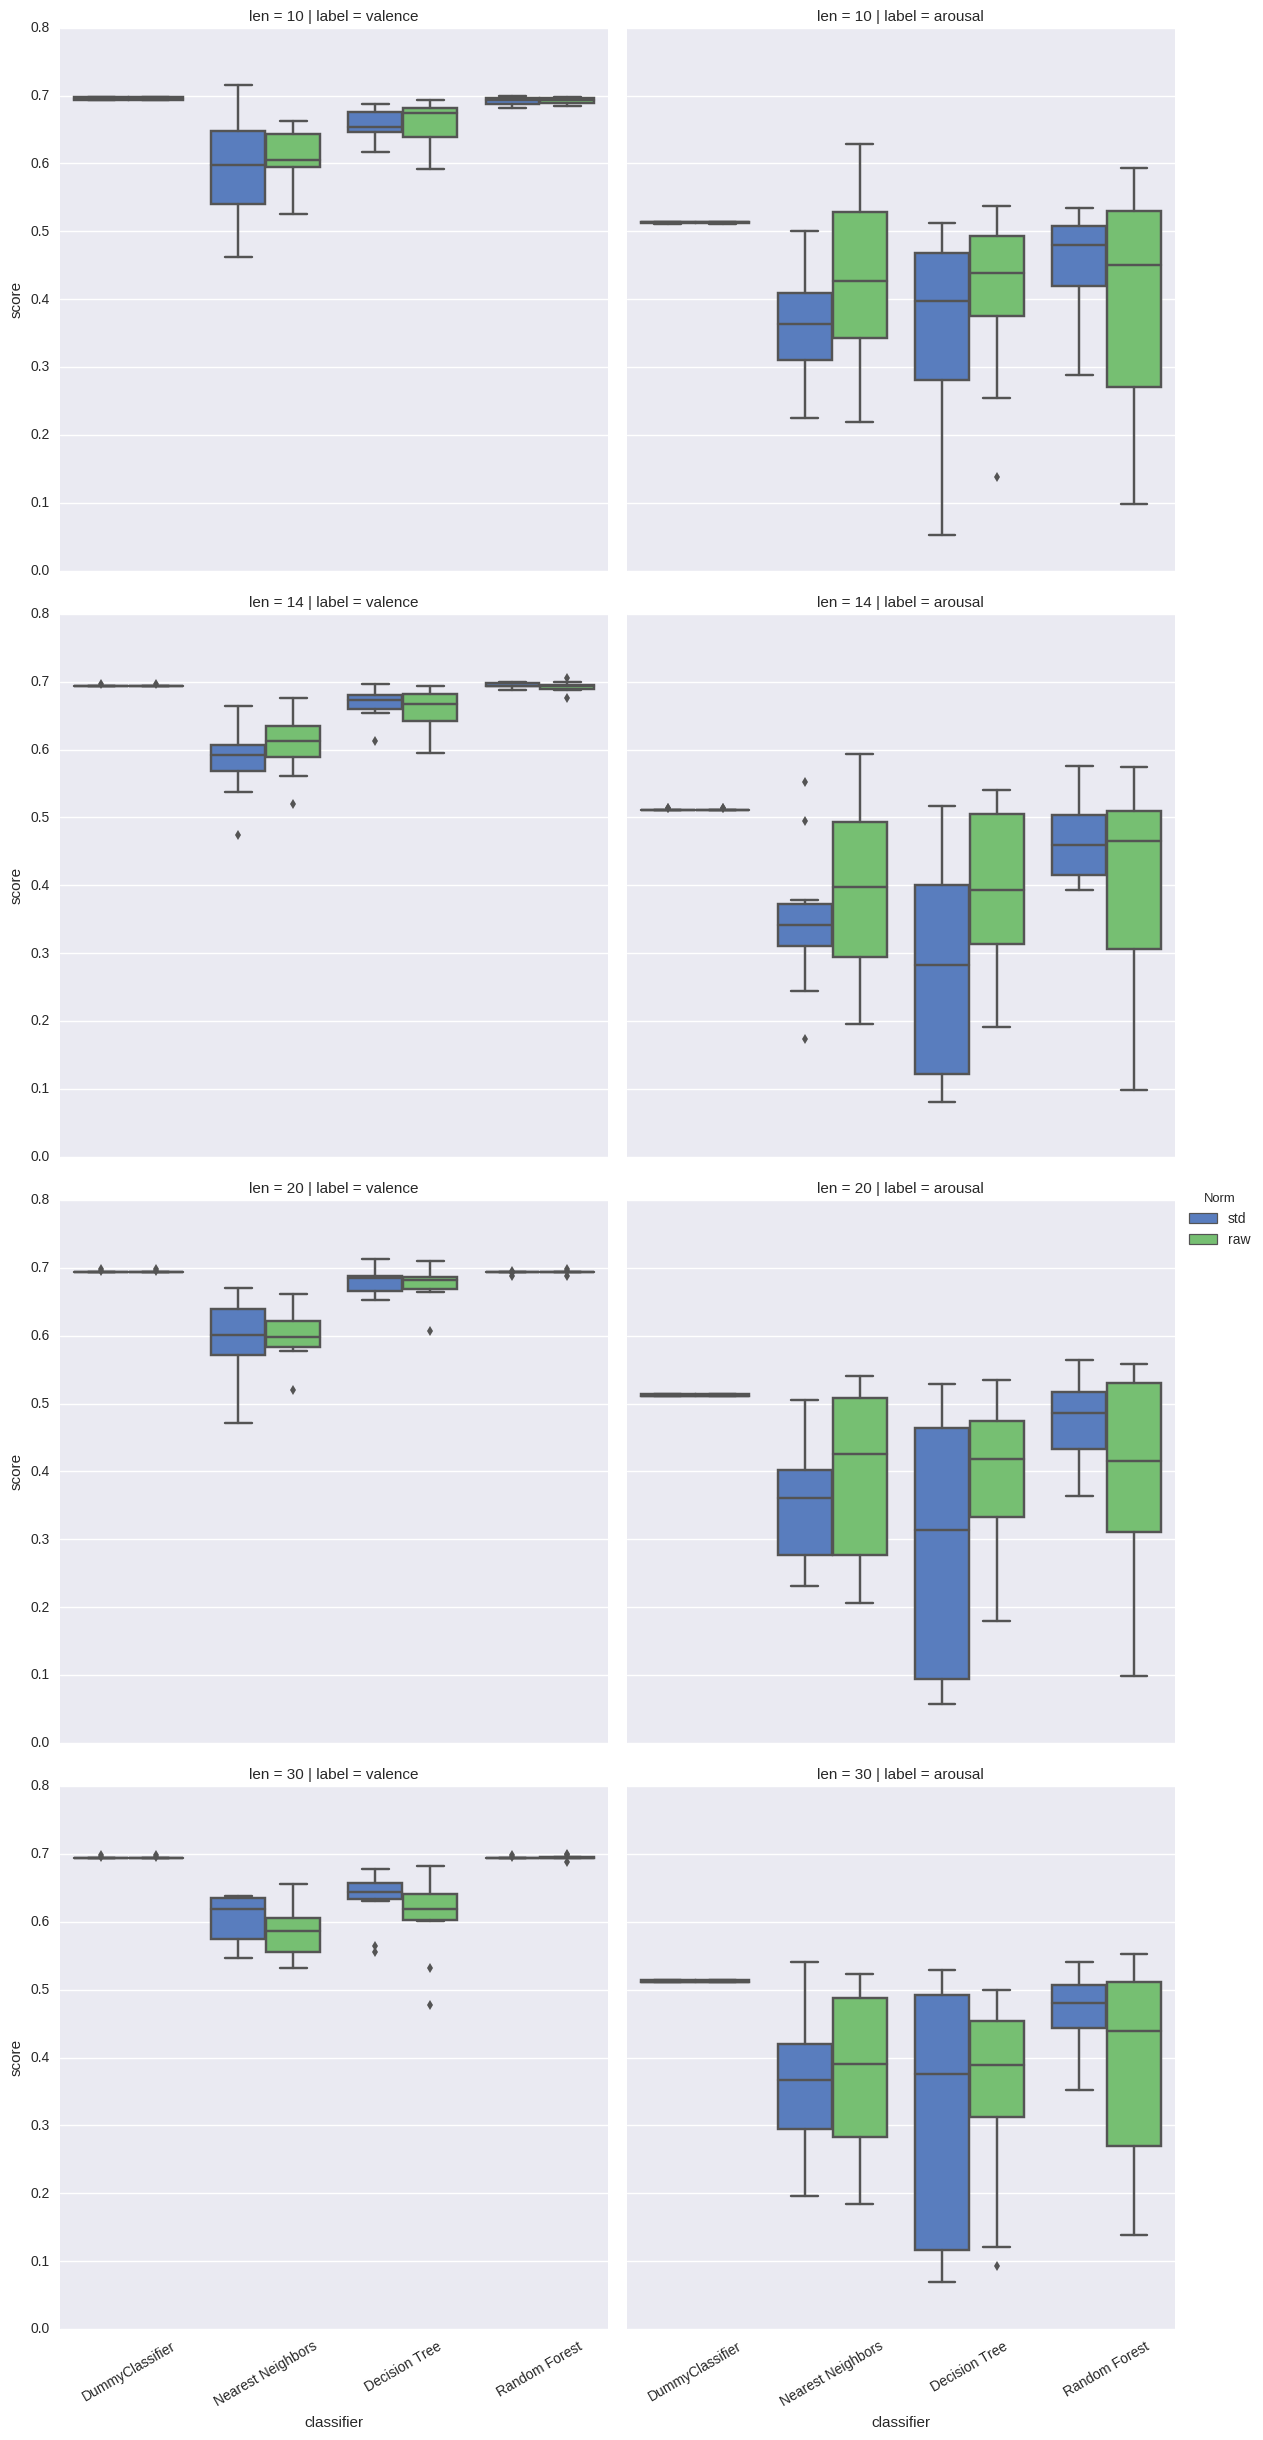

In [6]:
g = sns.factorplot(x="classifier", y="score", col='label',row='len',hue='Norm',data=cmpclassifierdf,
                   size=6, kind="box",palette="muted")
g.set_xticklabels(rotation=30)
g.despine(left=True)
g.set_ylabels("score")